In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as path_effects
from IPython.display import HTML

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr,spearmanr

from ebov_data import *

if locations:
    pass
else:
    status()
    setFocusCountries()
    setColourMaps()
    loadData()

typeface='Helvetica Neue' ## set default matplotlib font and font size
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

path='<iframe style="border: 0; width: 400px; height: 450px;" src="https://bandcamp.com/EmbeddedPlayer/album=1298725374/size=large/bgcol=333333/linkcol=2ebd35/artwork=small/track=3639588753/transparent=true/" seamless><a href="http://giriudvasios.bandcamp.com/album/ratu">Ratu by Giriu Dvasios</a></iframe>'

print 'Done!'
HTML(path)

Operating system:       Darwin (15.6.0)
Python version:         2.7.12
Numpy version:          1.11.3
Pandas version:         0.18.1
matplotlib version:      2.0.0
scipy version:          0.18.1

This notebook was last run on:
Sunday	2017-Feb-26	15:25	PDT
Done!


In [2]:
history_path=path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run1/Makona_1610_cds_ig.GLM.history.log' ## 

observed_jumps_to={y:0 for y in popCentres.keys()}
observed_jumps_from={y:0 for y in popCentres.keys()}

MCMClen=0

burnin=10000000
for line in open(history_path,'r'): ## iterate through the history file
    l=line.strip('\n').split('\t')
    if '#' in line or 'state' in line:
        pass
    elif float(l[0])>=burnin:
        MCMClen+=1
        try:
            N_transitions=int(float(l[-1]))
        except:
            N_transitions=int(float(line.split(' ')[-1].strip('\n')))
            
        cerberus=re.findall('{[0-9]+,[0-9\.]+,[A-Za-z]+,[A-Za-z]+}',l[2]) ## fetch all transitions

        
        for trans in cerberus: ## iterate over each event
            log,height,origin,destination=trans[1:-1].split(',')

            observed_jumps_to[destination]+=1 ## add time to known jumps to and from the locations
            observed_jumps_from[origin]+=1
            

        if len(cerberus)!=N_transitions: ## make sure that the number of found jumps matches what BEAST reported
            print 'Number of transitions found (%d) does not match reported number (%d) at state %s'%(len(cerberus),N_transitions,l[0])

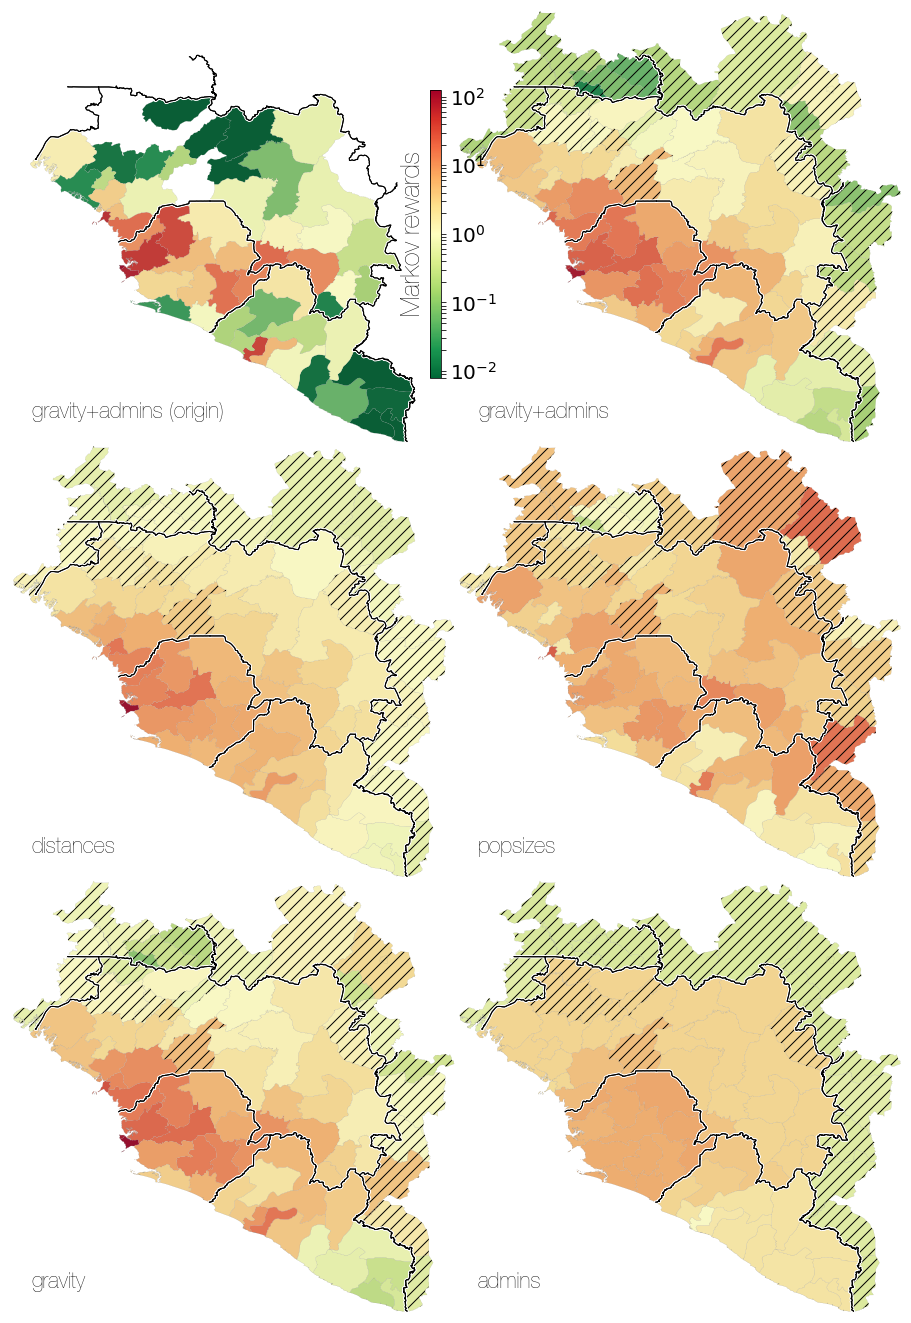

In [3]:
base_log_path=path_to_dropbox+'Sequences/Jun2016_1610_genomes/GLM/homogeneous/56_locations/Rewards_Included_Only/AllJumps/'

logs=['m_jumpsTO.81.admins.txt','m_jumpsTO.81.distances.txt','m_jumpsTO.81.gravity.txt','m_jumpsTO.81.gravity+admins.txt','m_jumpsTO.81.popsizes.txt']

receptions={}
for log in logs:
    predictor=log.split('.')[-2]
    receptions[predictor]={}
    for line in open(base_log_path+log,'r'):
        l=line.strip('\n').split('\t')
        if l[0]=='admin':
            pass
        else:
            receptions[predictor][l[0]]=float(l[1])
            
predictor='gravity+admins (origin)'
receptions[predictor]={}
for line in open(base_log_path+'m_jumpsFROM.56.gravity+admins.txt','r'):
    l=line.strip('\n').split('\t')
    if l[0]=='admin':
        pass
    else:
        receptions[predictor][l[0]]=float(l[1])

rows=3
cols=2

fig = plt.figure(figsize=(cols*8,rows*8),facecolor='w')

## define subplots
gs = gridspec.GridSpec(rows, cols,hspace=0.0,wspace=0.0)

cmap=mpl.cm.RdYlGn_r

global_minimum=-2.1
global_maximum=2.1

local_norm_up=create_normalization([0.0,global_maximum],0.5,1.0)
local_norm_lo=create_normalization([global_minimum,0.0],0.0,0.5)

keys=[predictor,'gravity+admins','distances','popsizes','gravity','admins']

for log,key in enumerate(keys):
    #local_maximum=np.log10(max([np.mean(x) for x in receptions[key].values()]))
    #local_minimum=np.log10(min([np.mean(x) for x in receptions[key].values()]))
    #print log,key,len(receptions[key].keys()),local_minimum,local_maximum
    
    row=int(log/cols)
    
    if row==0:
        col=log
    else:
        col=log%cols
        
    ax = plt.subplot(gs[row, col])
    
    for loc in receptions[key].keys():

        ## plot population centres
        lon,lat=popCentres[loc]

        jumps_to=np.log10(receptions[key][loc])
        
        if jumps_to<0.0:
            fc=cmap(local_norm_lo(jumps_to))
        elif jumps_to>0.0:
            fc=cmap(local_norm_up(jumps_to))

        ## plot district polygons
        h=''
        if cases_byLocation.has_key(loc)==False or sum(cases_byLocation[loc].values())==0:
            h='//'
        
        ax.add_collection(PatchCollection(polygons[loc],facecolor=desaturate(fc,0.8),edgecolor='grey',hatch=h,lw=0.1,zorder=0))
            
    for local_border in global_border:
        ax.plot(column(local_border,0),column(local_border,1),color='k',lw=1,zorder=2)
        ax.plot(column(local_border,0),column(local_border,1),color='w',lw=3,zorder=1) 
        
    ax.text(0.05,0.05,'%s'%(key),ha='left',va='bottom',transform=ax.transAxes)
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

Nticks=11
colourticks=[]
for t in np.linspace(global_minimum,global_maximum,Nticks):
    if t<0.0:
        colourticks.append(local_norm_lo(t))
    elif t>=0.0:
        colourticks.append(local_norm_up(t))

axcb = fig.add_axes([0.49, 1-1/float(rows), 0.01, 0.5/float(rows)], frame_on=False)
norm = mpl.colors.LogNorm(vmin=10**global_minimum, vmax=10**global_maximum)
cb = mpl.colorbar.ColorbarBase(axcb,norm=norm,cmap=cmap,orientation='vertical',alpha=1.0,drawedges=False)
  
axcb.yaxis.set_label_position("left")
axcb.set_ylabel('Markov rewards',size=26,rotation=90)
axcb.yaxis.labelpad=5
axcb.tick_params(axis='y',direction='out',size=5,labelsize=20)

# plt.savefig(local_output+'EBOV_expectedIntroductions.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_expectedIntroductions.pdf',dpi=300,bbox_inches='tight')
plt.show()

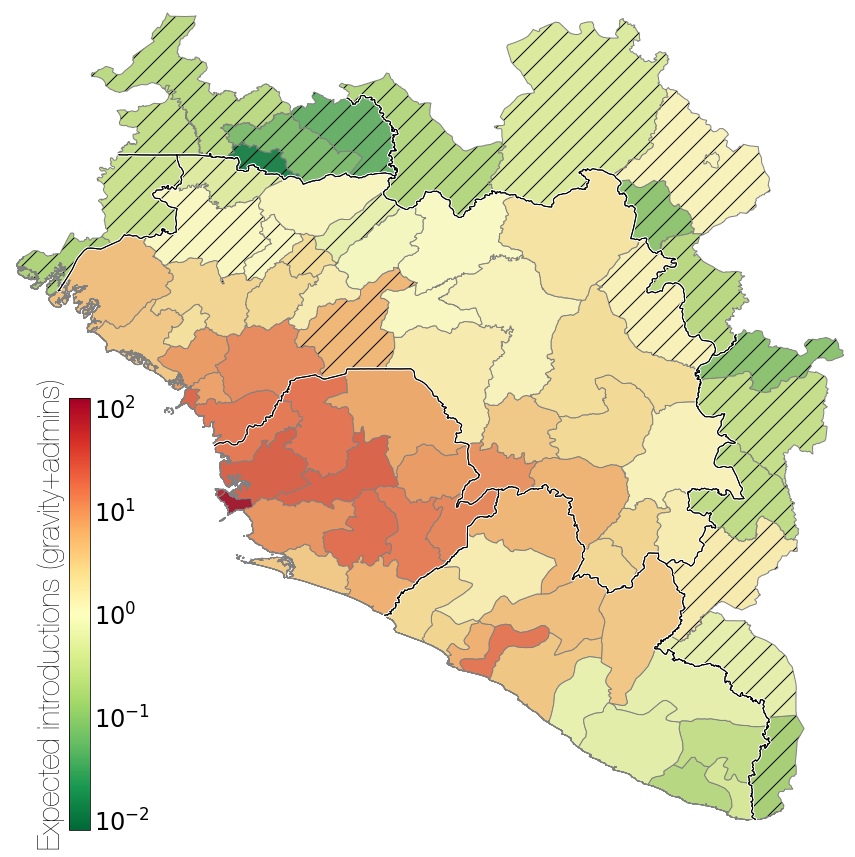

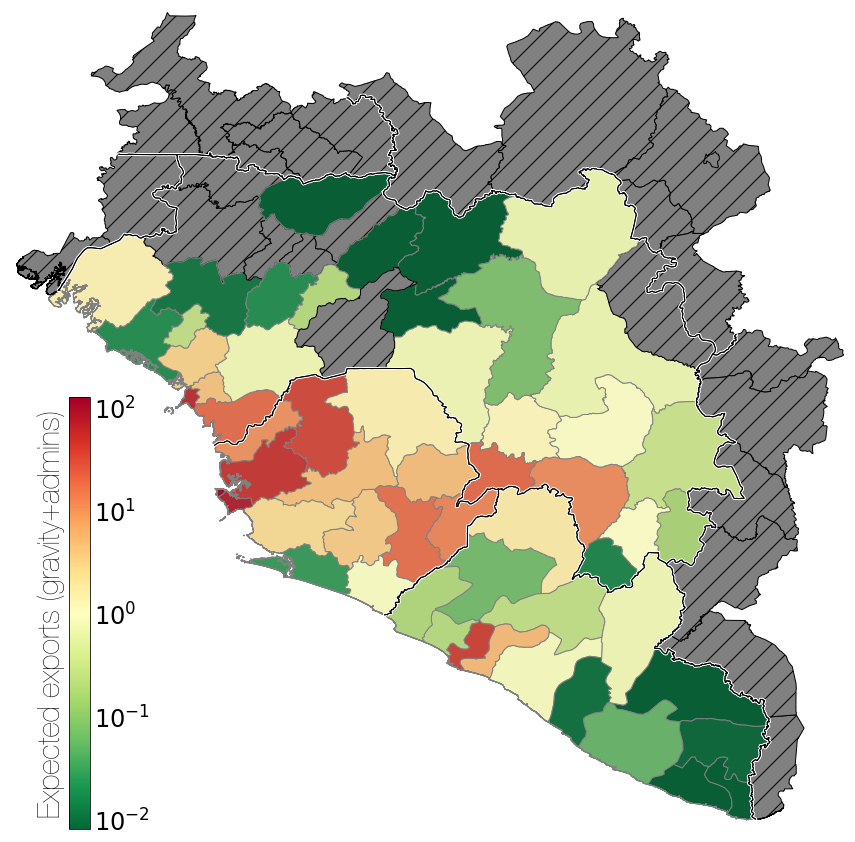

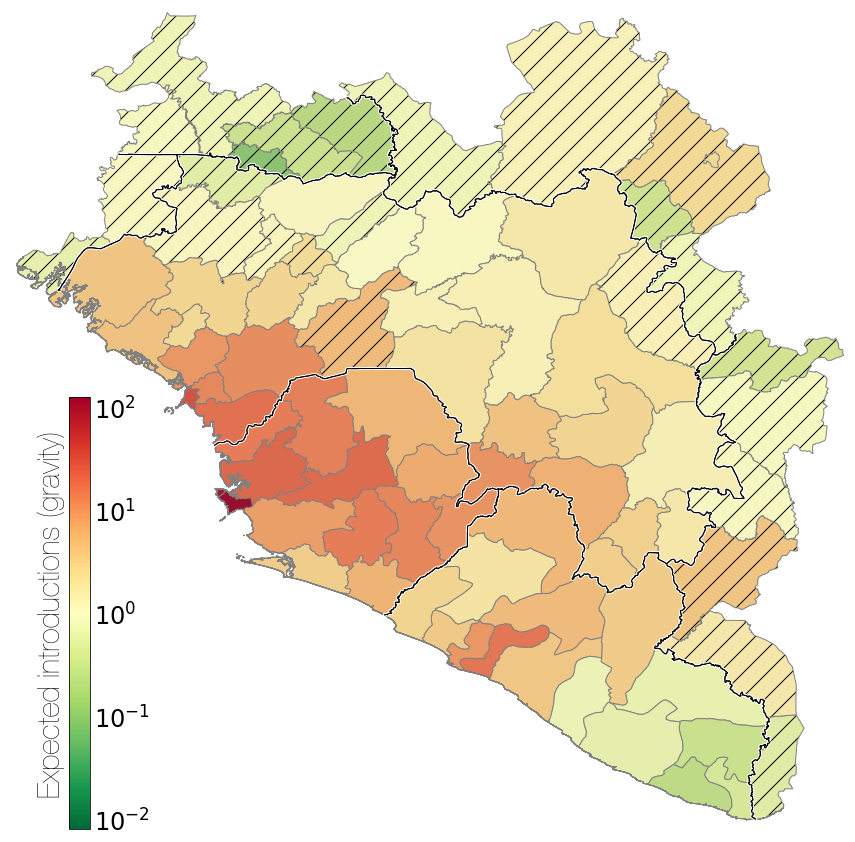

In [4]:
cmap=mpl.cm.RdYlGn_r

for kind in ['gravity+admins','gravity+admins (origin)','gravity']:
    fig,ax = plt.subplots(figsize=(15,15),facecolor='w')
    
    out_source=open(local_output+'%s_jumps.source.txt'%(kind),'w')
    print>>out_source,'country\tlocation\tlog posterior Markov jumps'
    for loc in locations:
        
        if loc in receptions[kind]:
            ## plot population centres
            #lon,lat=popCentres[loc]

            jumps_to=np.log10(receptions[kind][loc])
            
            print>>out_source,'%s\t%s\t%.4f'%(location_to_country[loc],loc,jumps_to)
            
            if jumps_to<0.0:
                fc=cmap(local_norm_lo(jumps_to))
            elif jumps_to>0.0:
                fc=cmap(local_norm_up(jumps_to))

            ## plot district polygons
            h=''
            if cases_byLocation.has_key(loc)==False or sum(cases_byLocation[loc].values())==0:
                h='/'

            ax.add_collection(PatchCollection(polygons[loc],facecolor=desaturate(fc,0.8),edgecolor='grey',
                                          hatch=h,lw=1,zorder=0))
        else:
            ax.add_collection(PatchCollection(polygons[loc],facecolor='grey',edgecolor='k',
                                          hatch='/',lw=1,zorder=0))
    out_source.close()
    
    for local_border in global_border:
        ax.plot(column(local_border,0),column(local_border,1),color='k',lw=1,zorder=2)
        ax.plot(column(local_border,0),column(local_border,1),color='w',lw=3,zorder=1) 

    #ax.text(0.05,0.05,'%s'%(key),ha='left',va='bottom',transform=ax.transAxes)
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ## add colourbars - colours are log-normalized
    colorbarTextSize=30
    colorbarTickLabelSize=24
    colorbarWidth=0.02
    colorbarHeight=0.4
    colorbarIncrement=0.08

    ax2 = fig.add_axes([0.1+colorbarIncrement, 0.12, colorbarWidth, colorbarHeight])
    mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=mpl.colors.LogNorm(vmin=10**-2.1,vmax=10**2.1))
    ax2.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)

    ax2.yaxis.set_label_position('left') 
    
    if 'origin' in kind:
        ax2.set_ylabel('Expected exports (gravity+admins)',color='k',size=colorbarTextSize)
        #plt.savefig(local_output+'ghost_sources.png',dpi=300,bbox_inches='tight')
        #plt.savefig(local_output+'ghost_sources.pdf',dpi=300,bbox_inches='tight')
    elif 'admins' in kind:
        ax2.set_ylabel('Expected introductions (gravity+admins)',color='k',size=colorbarTextSize)
        #plt.savefig(local_output+'ghost_destinations.png',dpi=300,bbox_inches='tight')
        #plt.savefig(local_output+'ghost_destinations.pdf',dpi=300,bbox_inches='tight')
    else:
        ax2.set_ylabel('Expected introductions (gravity)',color='k',size=colorbarTextSize)
        #plt.savefig(local_output+'ghost_gravity.png',dpi=300,bbox_inches='tight')
        #plt.savefig(local_output+'ghost_gravity.pdf',dpi=300,bbox_inches='tight')

    plt.show()

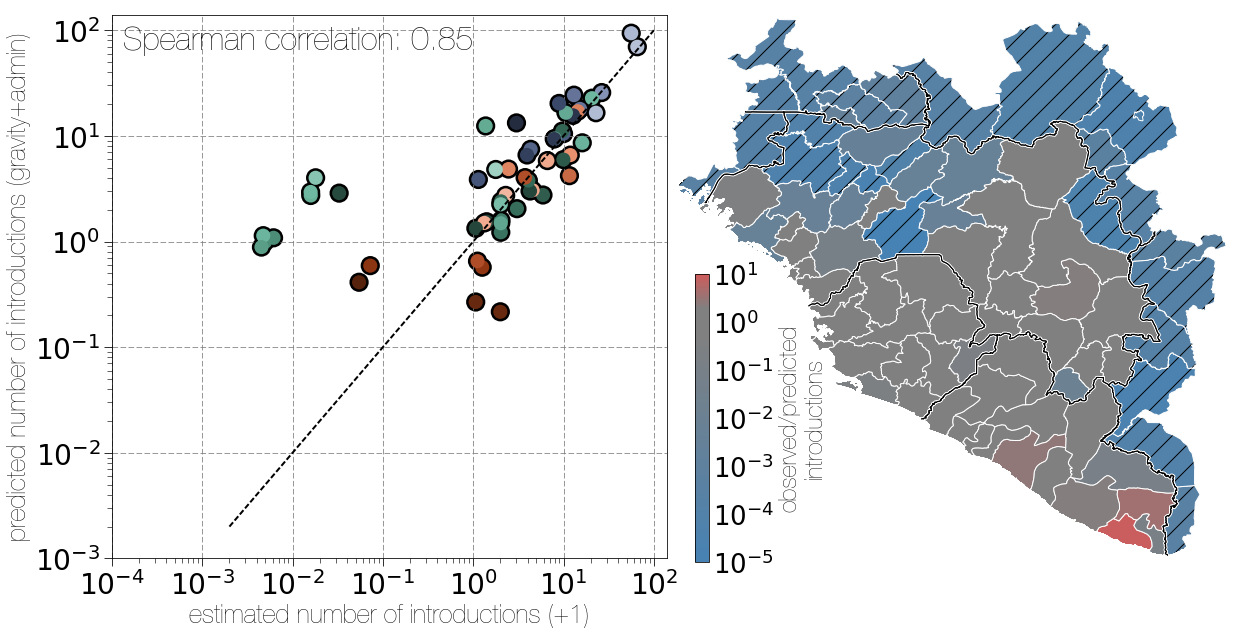

In [5]:
# fig,ax = plt.subplots(figsize=(15,15),facecolor='w')

fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.01) 

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xs=[]
ys=[]

for loc in sorted(locations,key=lambda l:-observed_jumps_to[l]):
    expected_jumps_to=receptions['gravity+admins'][loc]
    #ax.scatter(observed_jumps_to[loc]/float(MCMClen),expected_jumps_to)


    countryColour=colours[location_to_country[loc]]


    if sum(cases_byLocation[loc].values())==0:
        bc=countryColour(normalized_coords[loc])
        fc='w'
    else:
        bc='k'
        fc=countryColour(normalized_coords[loc])

    X=(observed_jumps_to[loc]+1)/float(MCMClen)
    Y=expected_jumps_to

    ax1.scatter(X,Y,s=200,facecolor=fc,edgecolor='none',zorder=2)
    ax1.scatter(X,Y,s=370,facecolor=bc,edgecolor='none',zorder=1)
    xs.append(X)
    ys.append(Y)
    
r2,pval=spearmanr(xs,ys)

ax1.plot([0.002,100.0],[0.002,100.0],lw=2,ls='--',color='k')

ax1.text(0.02,0.98,'Spearman correlation: %.2f'%(r2),size=32,transform=ax1.transAxes,va='top',ha='left')

ax1.set_xlim(0.0001,140.0)
ax1.set_ylim(0.001,140.0)
    
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('estimated number of introductions (+1)',size=26)
ax1.set_ylabel('predicted number of introductions (gravity+admin)',size=26)

ax1.tick_params(which='major',size=8,labelsize=28,direction='out')
ax1.tick_params(which='minor',size=5,direction='out')
ax1.grid(which='major',ls='--',color='grey')

# plt.savefig(local_output+'EBOV_OE_intros.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_OE_intros.pdf',dpi=300,bbox_inches='tight')

#plt.show()


#fig,ax = plt.subplots(figsize=(15,15),facecolor='w')

residuals=[a/b for a,b in zip(xs,ys)]
# norm=mpl.colors.LogNorm(min(residuals),max(residuals))

cmap=mpl.cm.viridis

vmin=-5
vmax=1
norm=mpl.colors.LogNorm(10**vmin,10**vmax)

ccoords=np.logspace(vmin,vmax,10)
clist=[]
# for c in ccoords:
#     q=np.log10(c)
#     if c<0.5 or c>2: ## if missed actual value by twice or half the amount
# #         clist.append(((q-vmin)/(vmax-vmin),cmap((q-vmin)/(vmax-vmin))))
#         if c<0.5:
#             clist.append(((q-vmin)/(vmax-vmin),'indianred'))
#         elif c>2.0:
#             clist.append(((q-vmin)/(vmax-vmin),'steelblue'))
#     else:
#         clist.append(((q-vmin)/(vmax-vmin),'grey'))
clist=[(0.0,'steelblue'),
       ((np.log10(0.5)-vmin)/(vmax-vmin),'grey'),
       ((np.log10(2.0)-vmin)/(vmax-vmin),'grey'),
       (1.0,'indianred')]

cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap',clist)

for loc in locations:
    expected_jumps_to=receptions['gravity+admins'][loc]
    
    X=(observed_jumps_to[loc]+1)/float(MCMClen)
    Y=expected_jumps_to
    
    fc=cmap(norm(X/Y))
    h=''
    if sum(cases_byLocation[loc].values())==0:
        h='/'
    ax2.add_collection(PatchCollection(polygons[loc],facecolor=fc,edgecolor='w',lw=1,hatch=h,zorder=0))

for local_border in global_border:
    ax2.plot(column(local_border,0),column(local_border,1),color='k',lw=1,zorder=2)
    ax2.plot(column(local_border,0),column(local_border,1),color='w',lw=3,zorder=1) 

#ax.text(0.05,0.05,'%s'%(key),ha='left',va='bottom',transform=ax.transAxes)
ax2.set_xlim(xlimits)
ax2.set_ylim(ylimits)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(size=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3 = fig.add_axes([0.53, 0.12, 0.01, 0.4])
mpl.colorbar.ColorbarBase(ax3, cmap=cmap,norm=norm)
ax3.tick_params(size=0,labelsize=26)
ax3.set_ylabel('observed/predicted\nintroductions',size=24)


# plt.savefig(local_output+'EBOV_introResiduals.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_introResiduals.pdf',dpi=300,bbox_inches='tight')

plt.show()

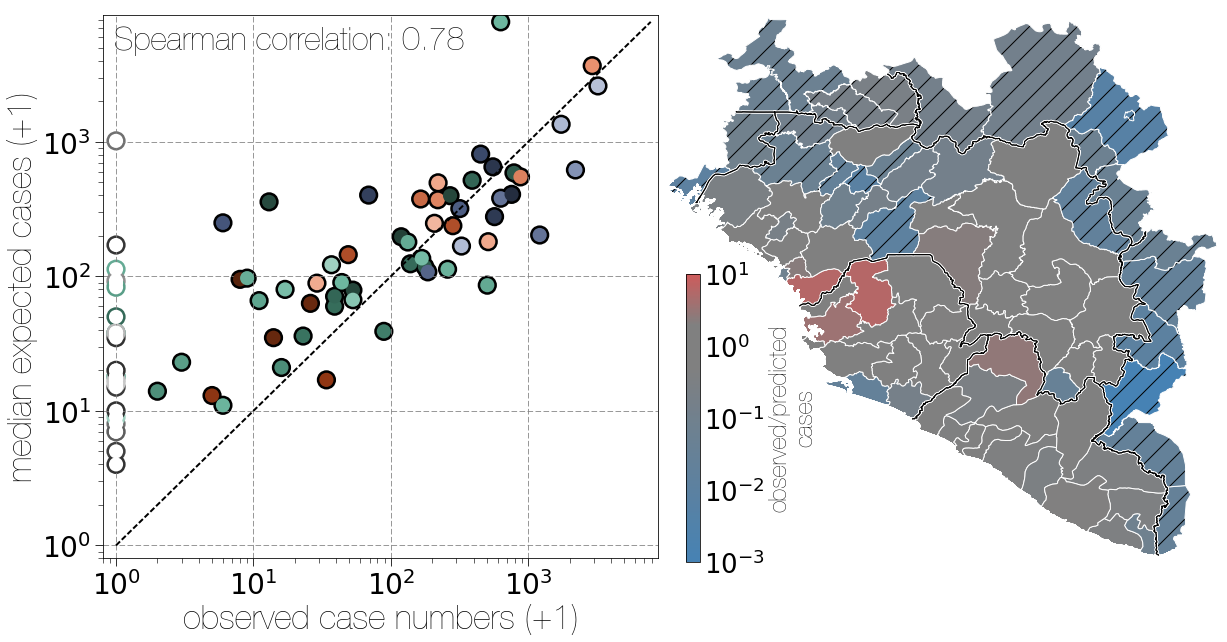

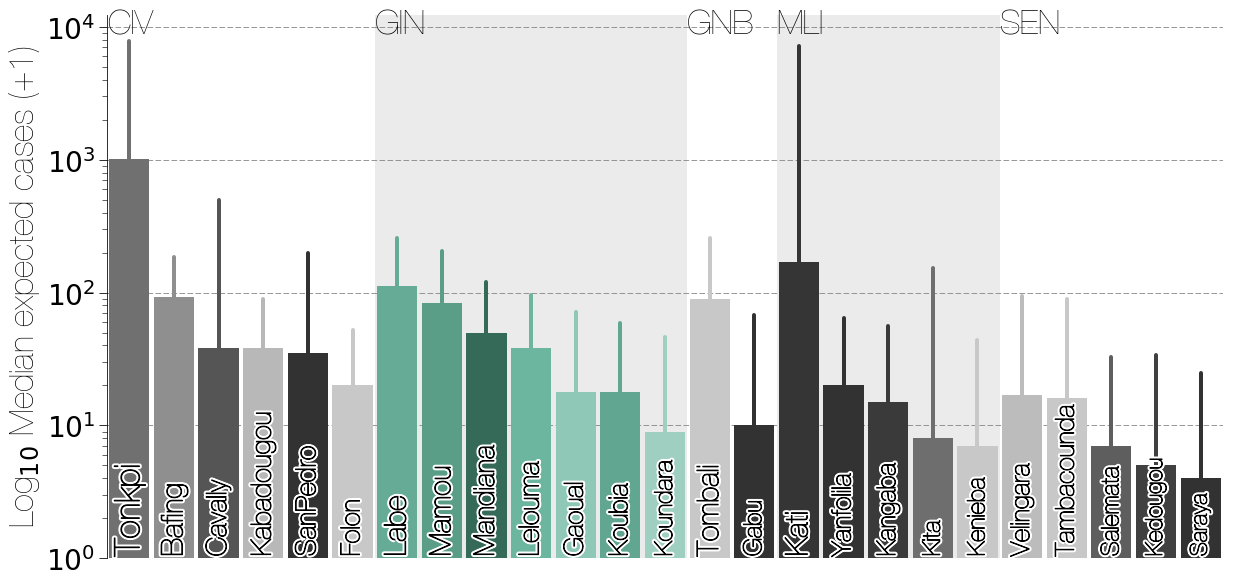

In [6]:
pred_cases_path=path_to_dropbox+'Location_GLM/predictions_negbin_RE_intercept_BEAST.csv'

observed={}
medians={}
lower={}
upper={}
# ['"location","lwr","mean","median","upr","true.counts"']
for line in open(pred_cases_path,'r'):
    l=line.strip('\n').split(',')
#         print l
    if 'location' not in l[0]:
        loc,predLo,predMean,predMed,predHi,true=l
        loc=loc.strip('"')
        observed[loc]=float(true)+1
        medians[loc]=float(predMed)+1
        lower[loc]=float(predLo)+1
        upper[loc]=float(predHi)+1
    else:
        header=l
        
#fig,ax = plt.subplots(figsize=(15,15),facecolor='w')
fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.01) 

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xs=[]
ys=[]

for loc in observed.keys():
    truth=observed[loc]
    predicted=medians[loc]
    pred_lower=lower[loc]
    pred_upper=upper[loc]
    
    countryColour=colours[location_to_country[loc]]
    
#     c='steelblue'
    if sum(cases_byLocation[loc].values())==0:
        bc=countryColour(normalized_coords[loc])
        fc='w'
    else:
        bc='k'
        fc=countryColour(normalized_coords[loc])

    ax1.scatter(truth,predicted,s=200,facecolor=fc,edgecolor='none',zorder=2)
    ax1.scatter(truth,predicted,s=370,facecolor=bc,edgecolor='none',zorder=1)
    xs.append(truth)
    ys.append(predicted)
    #ax.plot([truth,truth],[pred_lower,pred_upper],color=c,lw=2)
    
r2,pval=spearmanr(xs,ys)

ax1.text(0.02,0.98,'Spearman correlation: %.2f'%(r2),size=32,transform=ax1.transAxes,va='top',ha='left')

ax1.plot([1,max(medians.values())],[1,max(medians.values())],lw=2,ls='--',color='k')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xlim(0.8,max(medians.values())+1000)
ax1.set_ylim(0.8,max(medians.values())+1000)

ax1.set_xlabel('observed case numbers (+1)',size=34)
ax1.set_ylabel('median expected cases (+1)',size=34)

ax1.tick_params(which='major',size=8,labelsize=28,direction='out')
ax1.tick_params(which='minor',size=5,direction='out')
ax1.grid(which='major',ls='--',color='grey')

# plt.savefig(local_output+'EBOV_OE_cases.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_OE_cases.pdf',dpi=300,bbox_inches='tight')
# plt.show()


residuals=[a/b for a,b in zip(xs,ys)]

cmap=mpl.cm.viridis

vmin=-3
vmax=1
norm=mpl.colors.LogNorm(10**vmin,10**vmax)

ccoords=np.logspace(vmin,vmax,256)
clist=[]
# for c in ccoords:
#     q=np.log10(c)
#     if c<0.5 or c>2: ## if missed actual value by twice or half the amount
#         clist.append(((q-vmin)/(vmax-vmin),cmap((q-vmin)/(vmax-vmin))))
#     else:
#         clist.append(((q-vmin)/(vmax-vmin),'grey'))
clist=[(0.0,'steelblue'),
       ((np.log10(0.5)-vmin)/(vmax-vmin),'grey'),
       ((np.log10(2.0)-vmin)/(vmax-vmin),'grey'),
       (1.0,'indianred')]
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap',clist)


for loc in locations:
    X=observed[loc]
    Y=medians[loc]

    fc=cmap(norm(X/Y))
    h=''
    if sum(cases_byLocation[loc].values())==0:
        h='/'
    ax2.add_collection(PatchCollection(polygons[loc],facecolor=fc,edgecolor='w',lw=1,hatch=h,zorder=0))

for local_border in global_border:
    ax2.plot(column(local_border,0),column(local_border,1),color='k',lw=1,zorder=2)
    ax2.plot(column(local_border,0),column(local_border,1),color='w',lw=3,zorder=1) 

#ax.text(0.05,0.05,'%s'%(key),ha='left',va='bottom',transform=ax.transAxes)
ax2.set_xlim(xlimits)
ax2.set_ylim(ylimits)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(size=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3 = fig.add_axes([0.53, 0.12, 0.01, 0.4])
mpl.colorbar.ColorbarBase(ax3, cmap=cmap,norm=norm)
ax3.tick_params(size=0,labelsize=26)
ax3.set_ylabel('observed/predicted\ncases',size=24)

# plt.savefig(local_output+'EBOV_caseResiduals.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_caseResiduals.pdf',dpi=300,bbox_inches='tight')
plt.show()


fig,ax = plt.subplots(figsize=(20,10),facecolor='w')
sorted_predicted=sorted([x for x in medians.keys() if observed[x]==1.0 and medians[x]>1.0],key=lambda x:(location_to_country[x],-medians[x]))

#print sorted_predicted
rememberCountry=''
rememberStart=0
skip=False
for l,loc in enumerate(sorted_predicted):
    country=location_to_country[loc]
    
    if country!=rememberCountry:
        ax.text(l-0.5,1000+max([upper[w] for w in sorted_predicted]),'%s'%(country),size=34)
        if skip==False:
            ax.axvspan(rememberStart-0.5,l-0.5,facecolor='k',edgecolor='none',alpha=0.08)
            rememberStart=l
            skip=True
        elif skip==True:
            skip=False
            rememberStart=l
            
    rememberCountry=country

# sorted_predicted=sorted([x for x in medians.keys() if observed[x]==1.0 and medians[x]>1.0],key=lambda x:-medians[x])
for l,loc in enumerate(sorted_predicted):
    #print loc,medians[loc]
    countryColour=colours[location_to_country[loc]]
    c=countryColour(normalized_coords[loc])
    ax.bar(l,medians[loc],align='center',facecolor=c,edgecolor='none',lw=3,width=0.9,zorder=100)
    ax.plot([l,l],[lower[loc],upper[loc]],lw=4,color=c,solid_capstyle='round',zorder=99)
    
    effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1.0, foreground='k')]
    ax.text(l,1.04,'%s'%(loc),size=5*np.log10(medians[loc])+20,rotation=90,va='bottom',ha='center',path_effects=effects,zorder=101)
ax.set_yscale('log')

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# ax.set_xticks(range(len(sorted_predicted)))
# ax.set_xticklabels(sorted_predicted,rotation=90)

ax.tick_params(which='major',size=8,labelsize=28,direction='out')
ax.tick_params(which='minor',size=5,direction='out')
ax.tick_params(axis='x',size=0)
ax.set_xticklabels([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_ylabel('Log$_{10}$ Median expected cases (+1)',size=34)

ax.grid(axis='y',which='major',ls='--',color='grey',zorder=0)
ax.set_xlim(-0.5,len(sorted_predicted)-0.5)
ax.set_ylim(bottom=1.0)

# plt.savefig(local_output+'EBOV_potentialOutbreaks.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_potentialOutbreaks.pdf',dpi=300,bbox_inches='tight')
plt.show()

7803.0


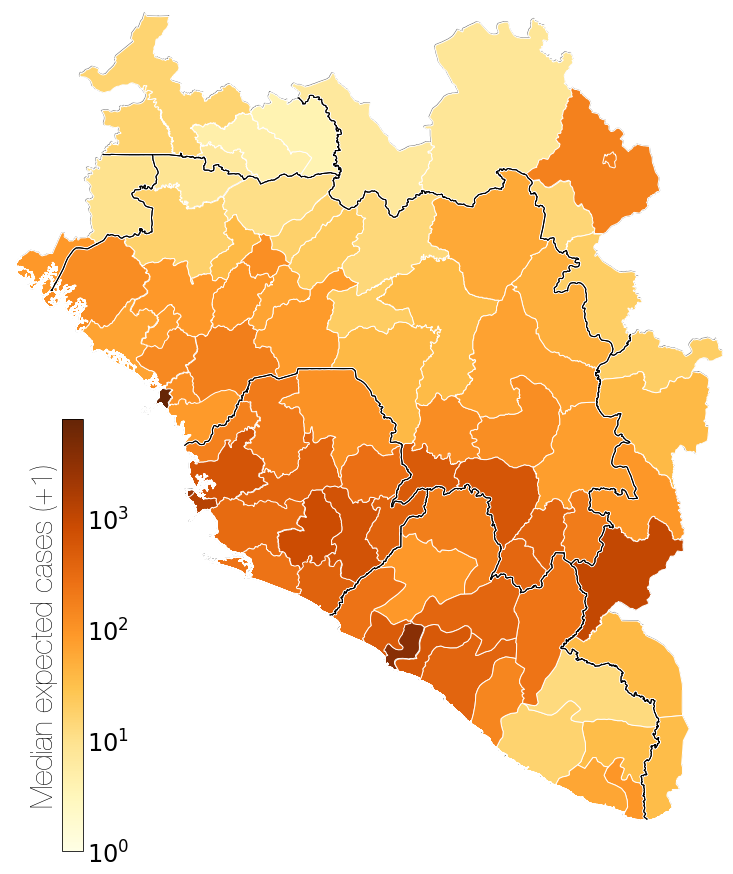

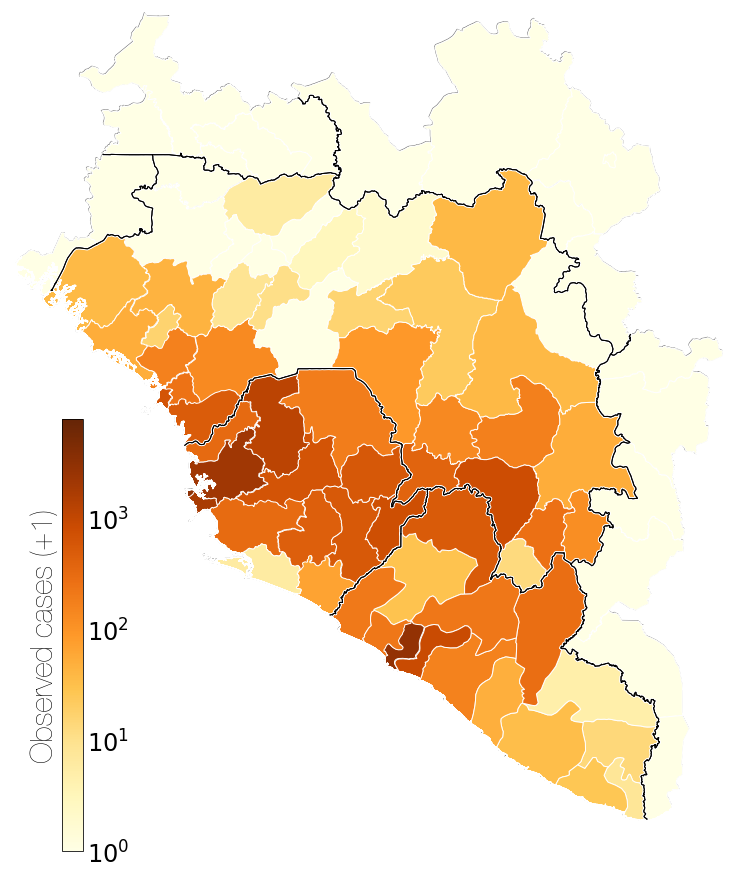

In [7]:
cmap=mpl.cm.YlOrBr

print max(medians.values())

for kind in [medians,observed]:
    fig,ax = plt.subplots(figsize=(15,15),facecolor='w')
    
    if kind==medians:
        out_source=open(local_output+'Fig4B_predictedCases.source.txt'%(kind),'w')
        print>>out_source,'country\tlocation\tpredicted median case numbers'
    
    for i,loc in enumerate(sorted(kind,key=lambda x:location_to_country[x])):
        country=location_to_country[loc]
        countryColour=colours[country]
        countryColour=cmap
        caseFrac=np.log10(kind[loc])/np.log10(max(medians.values()))
        c=countryColour(caseFrac)
        
        if kind==medians:
            print>>out_source,'%s\t%s\t%d'%(country,loc,kind[loc])
        
        ## plot location borders and polygons
        for part in location_points[loc]:
            ## mpl won't draw polygons unless there's something plotted
            xs=column(part,0)
            ys=column(part,1)
            ax.plot(xs,ys,color='grey',lw=1,zorder=0)

        ax.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor='w',lw=1,zorder=1))

        ## define available text alignments and corrections for text positions
        vas=['bottom','top']
        has=['left','right']
        corrections=[0.02,-0.02]

        effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='black')]
        ## set default text alignment (right, top)
        h=1
        v=1
        ## check if custom text positions are available
        if textCorrection.has_key(loc):
            h,v=textCorrection[loc]
    
    if kind==medians:
        out_source.close()
    
    ## add colourbars - colours are log-normalized
    colorbarTextSize=30
    colorbarTickLabelSize=24
    colorbarWidth=0.02
    colorbarHeight=0.4
    colorbarIncrement=0.08

    ax2 = fig.add_axes([0.15+colorbarIncrement, 0.1, colorbarWidth, colorbarHeight])
    mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=mpl.colors.LogNorm(vmin=1,vmax=max(medians.values())))
    ax2.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)
    ax2.yaxis.set_label_position('left') 
    if kind==medians:
        ax2.set_ylabel('Median expected cases (+1)',color='k',size=colorbarTextSize)
    else:
        ax2.set_ylabel('Observed cases (+1)',color='k',size=colorbarTextSize)

    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylim(ylimits)
    ax.set_xlim(xlimits)

    for local_border in global_border:
        ax.plot(column(local_border,0),column(local_border,1),lw=1,ls='-',color='k',zorder=3)
        ax.plot(column(local_border,0),column(local_border,1),lw=3,ls='-',color='w',zorder=2)
        
#     if kind==medians:
#         plt.savefig(local_output+'ghost_predicted_cases.png',dpi=300,bbox_inches='tight')
#         plt.savefig(local_output+'ghost_predicted_cases.pdf',dpi=300,bbox_inches='tight')
#     else:
#         plt.savefig(local_output+'ghost_observed_cases.png',dpi=300,bbox_inches='tight')
#         plt.savefig(local_output+'ghost_observed_cases.pdf',dpi=300,bbox_inches='tight')
    plt.show()

In [8]:
print max(medians.values()),max(observed.values())

7803.0 3220.0


negbin_noRE_withint/location_56_counts_negbin_noRE_withint.xml negbin_noRE_withint/location_56_counts_negbin_noRE_withint.GLM.log
['Pop_Size', 'geconMN', 'geconMIN', 'geconMAX', 'geconSTD', 'pdensMN', 'tt50kMN', 'tt100kMN', 'tt500kMN', 'altMN', 'tempMN', 'tmpssMN', 'precMN', 'precssMN']

predictor analysis:
idx                     predictor    N     ln coeff  pp       BF
  1*                      Pop_Size  9001     0.96    0.89     166.97
  2                        geconMN  9001     0.43    0.10       2.30
  3                       geconMIN  9001     0.42    0.07       1.59
  4                       geconMAX  9001     0.38    0.10       2.27
  5                       geconSTD  9001     0.23    0.02       0.40
  6                        pdensMN  9001    -0.17    0.01       0.28
  7*                       tt50kMN  9001    -0.69    0.52      21.32
  8                       tt100kMN  9001    -0.43    0.11       2.34
  9                       tt500kMN  9001    -0.38    0.04       0.89
 10  

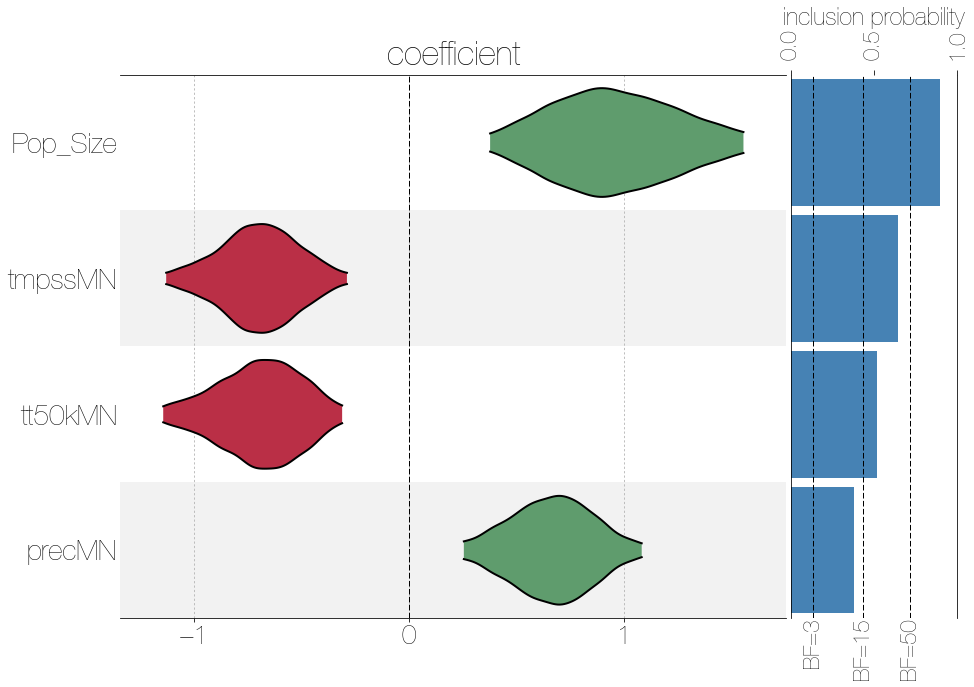

negbin_RE_noint/location_56_counts_negbin_RE_noint.xml negbin_RE_noint/location_56_counts_negbin_RE_noint.GLM.log
['Pop_Size', 'geconMN', 'geconMIN', 'geconMAX', 'geconSTD', 'pdensMN', 'tt50kMN', 'tt100kMN', 'tt500kMN', 'altMN', 'tempMN', 'tmpssMN', 'precMN', 'precssMN']

predictor analysis:
idx                     predictor    N     ln coeff  pp       BF
  1                       Pop_Size  9001     0.62    0.03       0.59
  2                        geconMN  9001     0.19    0.02       0.33
  3                       geconMIN  9001     0.30    0.02       0.34
  4                       geconMAX  9001     0.05    0.02       0.31
  5                       geconSTD  9001    -0.10    0.02       0.34
  6                        pdensMN  9001    -0.28    0.02       0.35
  7*                       tt50kMN  9001    -1.51    0.17       3.98
  8*                      tt100kMN  9001    -1.74    0.28       7.47
  9*                      tt500kMN  9001    -1.80    0.26       6.89
 10*                 

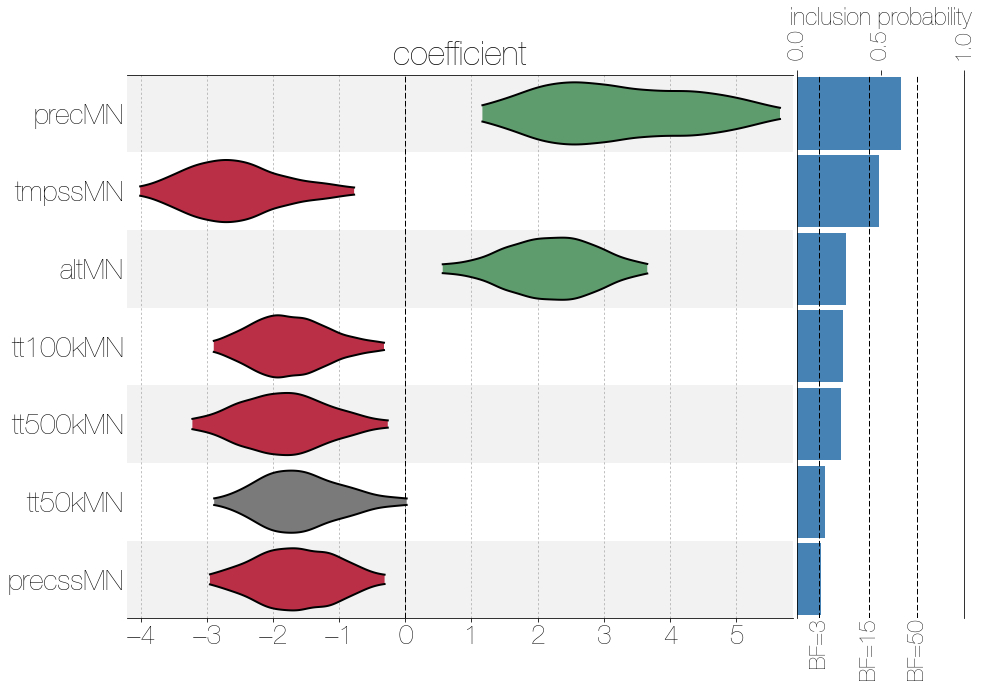

negbin_RE_withint/location_56_counts_negbin_RE_withint.xml negbin_RE_withint/location_56_counts_negbin_RE_withint.GLM.log
['Pop_Size', 'geconMN', 'geconMIN', 'geconMAX', 'geconSTD', 'pdensMN', 'tt50kMN', 'tt100kMN', 'tt500kMN', 'altMN', 'tempMN', 'tmpssMN', 'precMN', 'precssMN']

predictor analysis:
idx                     predictor    N     ln coeff  pp       BF
  1*                      Pop_Size  9001     0.90    0.60      29.59
  2                        geconMN  9001     0.39    0.04       0.73
  3                       geconMIN  9001     0.37    0.03       0.55
  4                       geconMAX  9001     0.39    0.05       0.93
  5                       geconSTD  9001     0.32    0.02       0.33
  6                        pdensMN  9001     0.01    0.01       0.11
  7*                       tt50kMN  9001    -0.90    0.62      32.38
  8*                      tt100kMN  9001    -0.77    0.16       3.79
  9                       tt500kMN  9001    -0.55    0.05       0.95
 10          

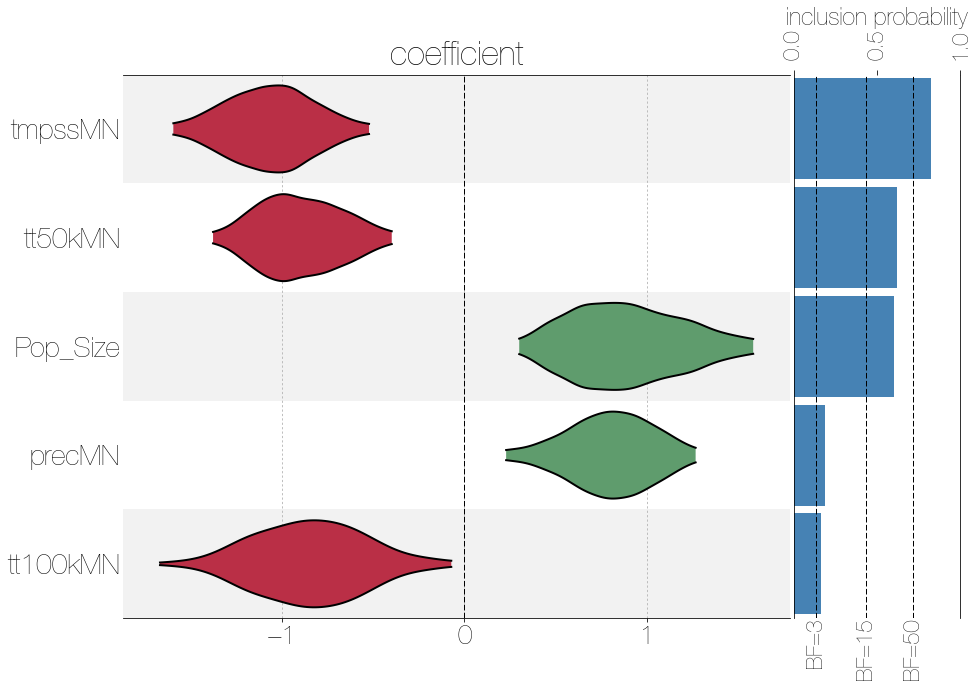

In [9]:
'/Users/evogytis/Dropbox/Ebolavirus_Phylogeography/'

per_path=path_to_dropbox+'Location_GLM/BEAST GLM/LOGS/darwin_runs/'

kinds=['negbin_noRE_withint','negbin_RE_noint','negbin_RE_withint']

logs=['%s/location_56_counts_%s.GLM.log'%(k,k) for k in kinds]
xmls=['%s/location_56_counts_%s.xml'%(k,k) for k in kinds]

# logs=['EVD_persistence_GLM_indicators.log','EVD_counts_negbin_GLM_indicators.log']
# xmls=['location_glm_persistence_56.xml','location_glm_counts_negativeBinomial_56.xml']

burnin=50000000


for xml,log in zip(xmls,logs):
    print xml,log
    leftedge=0
    rightedge=0
    
    per_predictors=[]
    readMatrix=False
    for line in open(per_path+xml,'r'):
        if '/designMatrix' in line and readMatrix==True:
            readMatrix=False
            
        if readMatrix==True:
            cerberus=re.search('<parameter id="([A-Za-z0-9\_]+)" value="',line)
            if 'intercept' not in cerberus.group(1):
                per_predictors.append(cerberus.group(1))
        
        if '<designMatrix id="GLM.' in line and readMatrix==False:
            readMatrix=True
    
    print per_predictors
    #print per_predictors  
    ## identify what the indicator and coefficient names in the log file will be
    required_coeffs=['GLM.glmCoefficients%d'%(x+1) for x in range(len(per_predictors))]
    required_indicators=['GLM.coefIndicator%d'%(x+1) for x in range(len(per_predictors))]

    per_GLM_indicators={x:[] for x in per_predictors}
    per_GLM_coeffs={x:[] for x in per_predictors}
    
    for line in open(per_path+log,'r'):
        l=line.strip('\n').split('\t')
        if '#' in line:
            pass
        elif l[0]=='state':
            header=l
            indices_coeffs=[i for i,x in enumerate(header) if x in required_coeffs]
            indices_indicators=[i for i,x in enumerate(header) if x in required_indicators]

        ## start logging posterior states past the burnin
        elif int(l[0])>=burnin:
            for i,j,x in zip(indices_coeffs,indices_indicators,per_predictors):
                per_GLM_indicators[x].append(float(l[j]))
                per_GLM_coeffs[x].append(float(l[i]))
        
        
    ##### find cutoff value for significant rates
    priorProbability=0.04830485
    priorOdds=float(priorProbability/float(1-priorProbability))

    ## BFs for individual indicators being on        
    BFs={}
    print '\npredictor analysis:'
    print '%3s%30s%5s%13s%4s%9s'%('idx','predictor','N','ln coeff','pp','BF')

    per_GLM_conditional_coeffs={}

    for i,x in enumerate(per_predictors):
        L=len(per_GLM_indicators[x])
        if L==0:
            per_GLM_coeffs.pop(x,None)
            per_GLM_indicators.pop(x,None)
        else:
            MCMClen=L
            support=np.mean(per_GLM_indicators[x])
            conditioned_coeff=[a for a,b in zip(per_GLM_coeffs[x],per_GLM_indicators[x]) if b==1.0]
            per_GLM_conditional_coeffs[x]=conditioned_coeff
            posteriorOdds=(((support-(1/float(MCMClen)))/float((1-(support-(1/float(MCMClen)))))))
            BFs[x]=posteriorOdds/float(priorOdds)
            note=' '
            if BFs[x]>3.0:
                note='*'
            print '%3s%s%30s%6d%9.2f%8.2f%11.2f'%(i+1,note,x,len(per_GLM_coeffs[x]),np.mean(conditioned_coeff),support,BFs[x])

    #print xml,log,[np.mean(GLM_coeffs[x]) for x in per_predictors]
        
    fig = plt.figure(figsize=(15, 10)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1],wspace=0.01) 

    ax = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
        
    ## set x labels for both figures
    ax2.set_xlabel('inclusion probability',size=24)
    ax.set_xlabel('coefficient',size=34)
        
    ax2.xaxis.set_label_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.labelpad=10
        
    ## sort predictor names by support, then by lower HPD, then by coefficient
    per_predictors=sorted(per_GLM_coeffs.keys(),key=lambda x:(np.mean(per_GLM_indicators[x]),np.mean(per_GLM_conditional_coeffs[x])))

    ## plot inclusion probabilities for BF=3 and BF=10
    plotBFs=[3,15,50]
    cutoffs={}
    for bf in plotBFs:
        posteriorOdds=priorOdds*bf
        cutoffs[bf]=(posteriorOdds/(1.0+posteriorOdds))
        print '%d Bayes factor cut-off = %.4f'%(bf,cutoffs[bf])
        ax2.axvline(cutoffs[bf],color='k',lw=1,ls='--')
        ax2.text(cutoffs[bf],-0.5,'BF=%d'%(bf),size=22,ha='center',va='top',rotation=90)

    
    significant=[x for x in per_GLM_conditional_coeffs.keys() if np.mean(per_GLM_indicators[x])>=min(cutoffs.values())]

    significant=sorted(significant,key=lambda x:(np.mean(per_GLM_indicators[x]),np.mean(per_GLM_conditional_coeffs[x])))
    
    ## for each predictor plot violins
    for i,x in enumerate(significant):        
        support=np.mean(per_GLM_indicators[x])
        ## if BF >minimum
        if support>=min(cutoffs.values()):
            ## if BF>3 then plot coefficients conditional on it being turned on
            posterior_samples=[val for val,ind in zip(per_GLM_coeffs[x],per_GLM_indicators[x]) if ind==1.0]
        else:
            ## otherwise plot all samples
            posterior_samples=per_GLM_coeffs[x]

        w=0.4

        ## estimate Gaussian KDE
        k1 = gaussian_kde(posterior_samples) #calculates the kernel density

        mu=np.mean(posterior_samples)

        ## get HPDs
        m1,M1=hpd(posterior_samples,0.95)

        if x in significant:
            #print predictor_description[x]
            posteriorOdds=(((support-(1/float(MCMClen)))/float((1-(support-(1/float(MCMClen)))))))
            BF=posteriorOdds/float(priorOdds)
            if BF>50.0:
                BF='%15s'%('>50')
            else:
                BF='%15.2f'%(BF)
            print '%s\t%.2f [%.2f, %.2f]\t%s'%(x,mu,m1,M1,BF)

        ## define new x axis minimum if new HPD is lower than current one
        if m1<=leftedge:
            leftedge=m1
        if M1>=rightedge:
            rightedge=M1

        ## create a range of 100 values between lower and upper HPDs
        x1 = np.linspace(m1,M1,100) 

        ## evaluate KDEs at each of the 100 values
        v1 = k1.evaluate(x1) 

        ## rescale to fit inside defined violin width
        v1 = v1/v1.max()*w 

        frac=np.mean([m1,M1])

        supportFrac=support/float(min(cutoffs.values()))
        if supportFrac>=1:
            supportFrac=1.0
#         supportFrac=1.0
    
        ## define fill colours for violins
        if M1<0.0 and m1<0.0:
            fcolour='#BA2F46'
        elif M1>0.0 and m1>0.0:
            fcolour=desaturate(mpl.cm.Greens(0.6),0.6)
        else:
            fcolour=desaturate(mpl.cm.Greys(0.6),0.6)

        ## plot violin, colour is desaturated depending on inclusion probability
        ax.fill_between(x1,[i+q for q in v1],[i-q for q in v1],facecolor=desaturate(fcolour,supportFrac),edgecolor='none',alpha=supportFrac,zorder=100)

        ## plot nice edges for each violin (upper and lower)
        fcolour='k'
        ax.plot(x1,[i+w for w in v1],color=desaturate(fcolour,supportFrac),lw=2,alpha=1,zorder=100)
        ax.plot(x1,[i-w for w in v1],color=desaturate(fcolour,supportFrac),lw=2,alpha=1,zorder=100)

        ## even numbered predictor - add a grey shaded area in the background
        if i%2==0:
            ax.axhspan(i-0.5,i+0.5,facecolor='k',edgecolor='none',alpha=0.05,zorder=0)

        ## plot inclusion probability
        ax2.barh(i,support,height=0.93,lw=2,align='center',edgecolor='none',
                 facecolor=desaturate('steelblue',supportFrac))

    ## define descriptions for each predictor to be used as y axis labels
    ylabels=[]
    for pred in significant:
        break_at=7
        #desc=predictor_description[pred]
        desc=pred
#         if len(desc.split(', +1'))>1:
#             description=''.join(desc.split(', +1')[:-1])
#         elif len(desc.split('pseudo'))>1:
#             description=''.join(desc.split(', pseudo')[:-1])
#         elif len(desc.split('ln-'))>1:
#             description=''.join(desc.split(', ln')[:-1])
#         elif len(desc.split(',  0'))>1:
#             description=''.join(desc.split(',  0')[:-1])
#         else:
#             description=desc

        ## breaks up the description into new lines to fit nicely
        #break_description='\n'.join([' '.join([y for y in description.split(' ')[x:x+break_at]]) for x in range(0,len(description.split(' ')),break_at)])

        ylabels.append(pred)
    #     ylabels.append(r'%s'%(break_description))

    ## add a horizontal line to main plot at coeff=0
    ax.axvline(0,ls='--',lw=1,color='k')
    ax.grid(axis='x',ls=':')

    ## make plot pretty
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')

    ax.yaxis.tick_left()

    ax.set_yticks(np.arange(0,len(ylabels)))
    ax.set_yticklabels(ylabels,size=28)

    ax2.xaxis.tick_top()
    ax2.set_xticks(np.linspace(0,1,3))
    ax2.set_xticklabels(np.linspace(0,1,3),rotation=90)
    ax2.tick_params(axis='y',size=0)
    ax2.set_yticklabels([])
    ax2.tick_params(axis='x',size=5,labelsize=22,direction='out',pad=10)


    ax2.spines['top'].set_color('none')
    ax2.spines['bottom'].set_color('none')

    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ax.tick_params(axis='x',labelsize=26,direction='out')
    ax.tick_params(axis='y',size=0)

    ax.set_ylim(-0.5,len(ylabels)-0.5)
    ax2.set_ylim(-0.5,len(ylabels)-0.5)
    ax.set_xlim(leftedge-0.2,rightedge+0.2)
    ax2.set_xlim(0,1)

#     plt.savefig(local_output+'%s_coeff.png'%(log.split('.')[0].split('_',log.count('_')-2)[-1]),dpi=300,bbox_inches='tight')
#     plt.savefig(local_output+'%s_coeff.pdf'%(log.split('.')[0].split('_',log.count('_')-2)[-1]),dpi=300,bbox_inches='tight')
    
    plt.show()

SpearmanrResult(correlation=0.84858842224373754, pvalue=1.4826930648672438e-16)


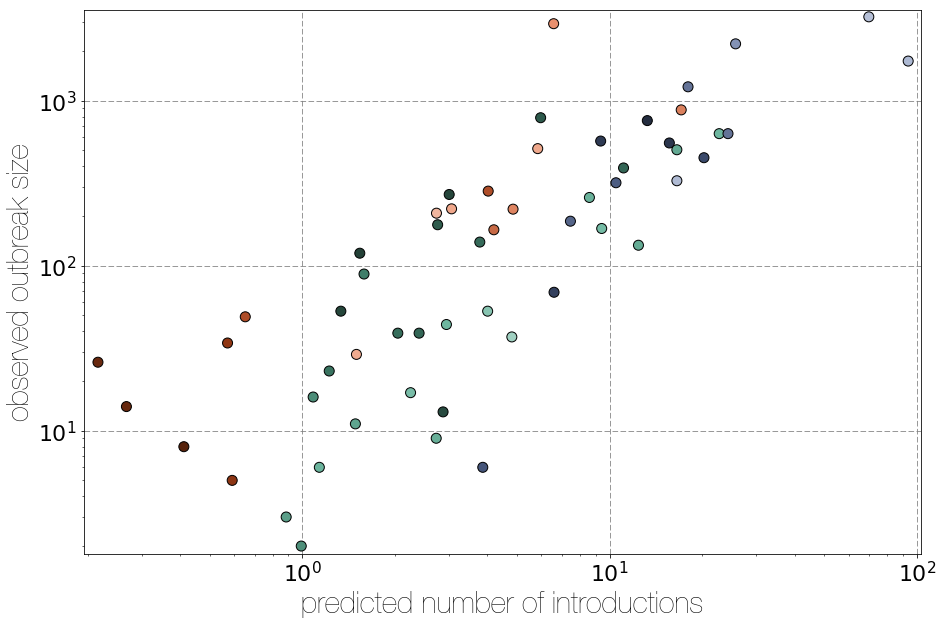

In [10]:
introductions=[]
predicted_cases=[]
observed_cases=[]
order=[]
popsize=[]
pdens=[]
sum_path=path_to_dropbox+'Location_GLM/sparks/sparky.csv'

for line in open(sum_path,'r'):
    l=line.strip('\n').split(',')
    if l[0]!='location':
        order.append(l[0])

#         introductions.append(float(l[1]))
        introductions.append(float(l[5]))
        predicted_cases.append(float(l[3])+1)
        observed_cases.append(float(l[4])+1)
        #popsize.append(float(l[4]))
        #pdens.append(float(l[5]))
        
fig,ax = plt.subplots(figsize=(15,10),facecolor='w')
#print len(order),np.log10(introductions)
#print spearmanr(predicted_cases,introductions)
cs=[colours[location_to_country[loc]](normalized_coords[loc]) for loc in order]



# case_perIntro=[x/y for x,y in zip(observed_cases,introductions)]
# xs=introductions
xs=[receptions['gravity+admins'][loc] for loc in order]
# ys=[x/y for x,y in zip(predicted_cases,observed_cases)]
ys=observed_cases
# ys=[y/x for x,y in zip(predicted_cases,observed_cases)]

#print order,ys
#print [location_to_country[loc] for loc in order]

ax.scatter(xs,ys,s=100,facecolor=cs,edgecolor='k',zorder=10)
print spearmanr(xs,ys)


ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(min(xs)*0.5,max(xs)*1.5)
ax.set_xlim(min(xs)*0.9,max(xs)*1.1)
ax.set_ylim(min(ys)*0.9,max(ys)*1.1)
ax.grid(which='major',color='grey',ls='--',zorder=0)
# ax.set_aspect(1)

# ax.set_xlabel('estimated number of introductions',size=30)
ax.set_xlabel('predicted number of introductions',size=30)
# ax.set_ylabel('predicted/observed outbreak size (+1)',size=24)
ax.set_ylabel('observed outbreak size',size=30)
# ax.set_ylabel('observed/predicted outbreak size (+1)',size=24)


# plt.savefig(local_output+'intro_predObs.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'intro_predObs.pdf',dpi=300,bbox_inches='tight')

# plt.savefig(local_output+'intro_Obs.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'intro_Obs.pdf',dpi=300,bbox_inches='tight')

# plt.savefig(local_output+'intro_obsPred.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'intro_obsPred.pdf',dpi=300,bbox_inches='tight')

# plt.savefig(local_output+'predIntro_obsCases.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'predIntro_obsCases.pdf',dpi=300,bbox_inches='tight')


plt.show()

SpearmanrResult(correlation=0.64907723855092281, pvalue=6.2743309805301319e-08)


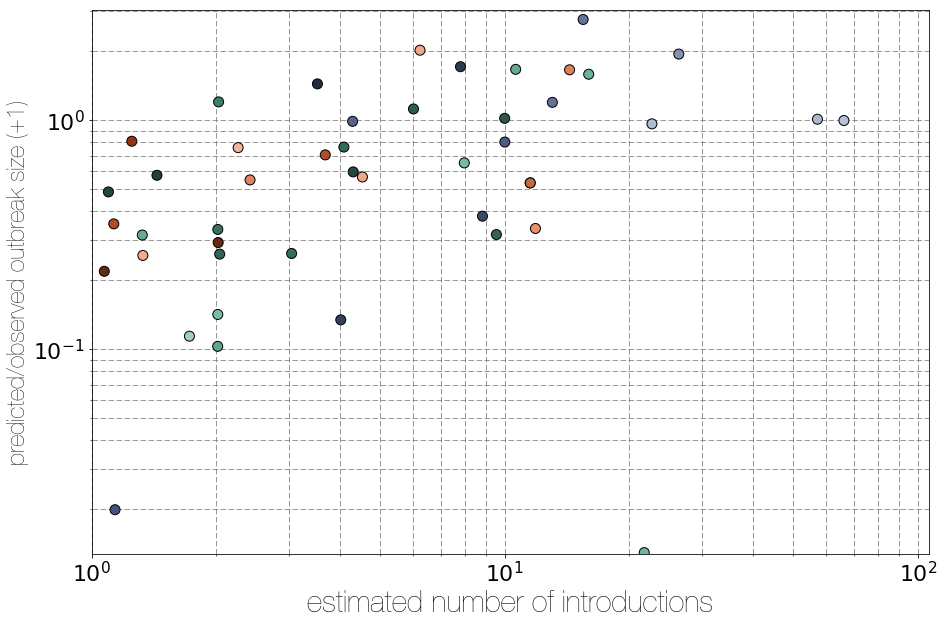

In [11]:
introductions=[]
predicted_cases=[]
observed_cases=[]
order=[]
popsize=[]
pdens=[]
sum_path=path_to_dropbox+'Location_GLM/sparks/sparky.csv'

for line in open(sum_path,'r'):
    l=line.strip('\n').split(',')
    if l[0]!='location':
        order.append(l[0])
#         introductions.append(float(l[1]))
        introductions.append(float(l[5]))
        predicted_cases.append(float(l[3])+1)
        observed_cases.append(float(l[4])+1)
        #popsize.append(float(l[4]))
        #pdens.append(float(l[5]))
        
fig,ax = plt.subplots(figsize=(15,10),facecolor='w')
#print len(order),np.log10(introductions)
#print spearmanr(predicted_cases,introductions)
cs=[colours[location_to_country[loc]](normalized_coords[loc]) for loc in order]



# case_perIntro=[x/y for x,y in zip(observed_cases,introductions)]
xs=introductions
# ys=[x/y for x,y in zip(predicted_cases,observed_cases)]
# ys=observed_cases
ys=[y/x for x,y in zip(predicted_cases,observed_cases)]

#print order,ys
#print [location_to_country[loc] for loc in order]

ax.scatter(xs,ys,s=100,facecolor=cs,edgecolor='k',zorder=10)
print spearmanr(xs,ys)


ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(min(xs)*0.5,max(xs)*1.5)
ax.set_xlim(1,max(xs)+40)
ax.set_ylim(min(ys)*0.99,max(ys)*1.1)
ax.grid(which='both',color='grey',ls='--',zorder=0)
# ax.set_aspect(1)

ax.set_xlabel('estimated number of introductions',size=30)
ax.set_ylabel('predicted/observed outbreak size (+1)',size=24)
# ax.set_ylabel('observed outbreak size',size=30)
# ax.set_ylabel('observed/predicted outbreak size (+1)',size=24)


# plt.savefig(local_output+'intro_predObs.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'intro_predObs.pdf',dpi=300,bbox_inches='tight')

# plt.savefig(local_output+'intro_Obs.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'intro_Obs.pdf',dpi=300,bbox_inches='tight')

# plt.savefig(local_output+'intro_obsPred.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'intro_obsPred.pdf',dpi=300,bbox_inches='tight')


plt.show()

In [12]:
fnames=['First_787/tmp_Makona_787_cds_ig.GLM.log','All_1610/Run1/Makona_1610_cds_ig.GLM.log']
#Makona_787_cds_ig.joint_GLM.xml
burnin=10000000
stats={'treeModel.rootHeight':{},'meanRate':{}}
skygrids={}
cutoffs={}
mostRecent={}
dates={}

GLMcoeffs={}
GLMinds={}

predictors=[]
predictor_description={}

for fname in fnames:
    
    print fname.split('/')[-1]
    dataset=fname.replace('tmp_','').split('/')[-1].split('_')[1]
    
    
    for stat in stats:
        stats[stat][dataset]=[]
    
    xml=fname.replace('.GLM.log','.joint_GLM.xml').replace('tmp_','')
    
    dates[dataset]=[]
    store=''
    counter=0
    for line in open(path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/'+xml,'r'):
        #print line
        cerberus=re.search('<date value="([0-9\.]+)" direction="forwards" units="years"/>',line)
        if cerberus is not None:
            dates[dataset].append(float(cerberus.group(1)))

            
        descriptionRegex='<!-- predictor [0-9]+\: ([A-Za-z\_\.\(\)\-0-9\, +>]+) -->'
        matrixRegex='<parameter id="([A-Za-z0-9\_\.]+)" value="'
    
        matrixID=re.search(matrixRegex,line) ## search for matrix
        valid_description=re.search(descriptionRegex,store) ## look at whether previous line was a valid description of a predictor
        if matrixID is not None and valid_description is not None:
            predictor=matrixID.group(1)
            if predictor not in predictors:
                predictors.append(predictor)
            predictor_description[predictor]=description
            counter+=1

        descriptionID=re.search(descriptionRegex,line) ## search for matrix description
        if descriptionID is not None:
            description=descriptionID.group(1)

        store=line ## remember line for next iteration
               
    mostRecent[dataset]=max(dates[dataset])
    
    for line in open(path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/'+fname,'r'):
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            
            indices={x:i for i,x in enumerate(header) if x in stats.keys()}
            
            skies={x:i for i,x in enumerate(header) if 'logPopSize' in x}
            skygrids[dataset]={x:[] for x in skies.keys()}
            cf=header.index('skygrid.cutOff')
            
            coeff_idx={x:i for i,x in enumerate(header) if 'location.glmCoefficients' in x}
            ind_idx={x:i for i,x in enumerate(header) if 'location.coefIndicator' in x}
            
            GLMcoeffs[dataset]={x:[] for x in coeff_idx.keys()}
            GLMinds[dataset]={x:[] for x in ind_idx.keys()}
#             print indices
        elif '#' in line:
            pass
        elif int(l[0])>burnin:
            for stat in indices.keys():
                if 'rootHeight' not in stat:
                    stats[stat][dataset].append(float(l[indices[stat]])*1e3)
                else:
                    stats[stat][dataset].append(mostRecent[dataset]-float(l[indices[stat]]))
                    
            for grid_pt in skies.keys():
                skygrids[dataset][grid_pt].append(float(l[skies[grid_pt]]))
                
            cutoffs[dataset]=float(l[cf])
            
            
            for coef,ind in zip(coeff_idx.keys(),ind_idx.keys()):
                GLMcoeffs[dataset][coef].append(float(l[coeff_idx[coef]]))
                GLMinds[dataset][ind].append(float(l[ind_idx[ind]]))
    
    #print skygrids[dataset].keys()
    print len(stats[stat][dataset])

tmp_Makona_787_cds_ig.GLM.log
13242
Makona_1610_cds_ig.GLM.log
19000


0 meanRate
787 meanRate 1.27	1.38	1.16
1610 meanRate 1.21	1.28	1.14


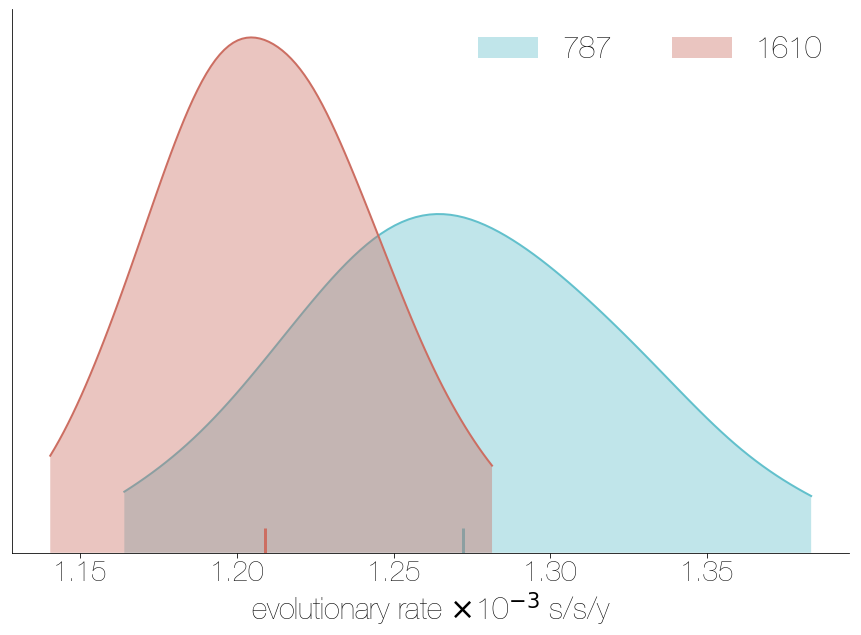

1 treeModel.rootHeight
787 treeModel.rootHeight 2014.08	2014.16	2014.00
1610 treeModel.rootHeight 2014.06	2014.14	2013.96


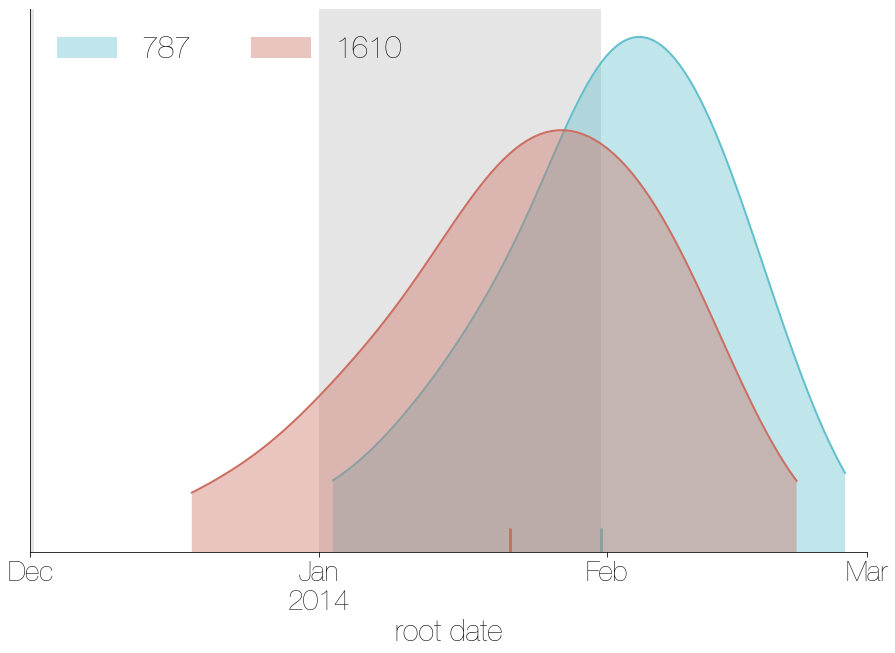

In [13]:
#fig = plt.figure(figsize=(15, 5)) 
#gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.12) 

cmap=mpl.cm.viridis
cs=['#62C0CC','#CC6E62']

for s,stat in enumerate(stats.keys()):
    fig,ax = plt.subplots(figsize=(15,10),facecolor='w')
    print s,stat
    #ax=plt.subplot(gs[1-s])
    
    datasets=stats[stat].keys()
    for f in datasets:
        #print f
        hpdHi,hpdLo=hpd(stats[stat][f],0.95)
        x_grid=np.linspace(hpdLo,hpdHi,100)
        kde=gaussian_kde(stats[stat][f],0.3)
        
        y_grid=kde.evaluate(x_grid)
        #fc=cmap(datasets.index(f)/float(len(datasets)-1))
        mu=np.mean(stats[stat][f])
        
        print f,stat,'%.2f\t%.2f\t%.2f'%(mu,hpdLo,hpdHi)
        
        fc=cs[datasets.index(f)]
        ax.fill_between(x_grid,y_grid,facecolor=fc,edgecolor='none',alpha=0.4,label=f,zorder=int(f))
        ax.plot(x_grid,y_grid,color=fc,lw=2,zorder=int(f))
        ax.eventplot([mu],linelengths=[1.0],lineoffsets=[0],color=[fc],lw=3,zorder=1000)
        
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
#     ax.spines['left'].set_color('none')
#     ax.spines['bottom'].set_color('none')
    ax.tick_params(axis='x',size=5,labelsize=28,direction='out')
    ax.tick_params(axis='y',size=0,direction='out')
    ax.set_yticklabels([])
    ax.legend(frameon=False,ncol=3,fontsize=30)
    if s==0:
        
        ax.set_xlabel(r'evolutionary rate $\times$10$^{-3}$ s/s/y',size=30)
    else:
        xDates=['%04d-%02d-01'%(Y,M) for Y in range(2013,2015) for M in range(1,13)]
        ax.set_xticks([decimalDate(x) for x in xDates])
        ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates])
        
    
        [ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/12.,facecolor='k',
                    edgecolor='none',alpha=0.1) for x in range(0,len(xDates),2)]

        ax.set_xlim(decimalDate('2013-12-01'),decimalDate('2014-03-01'))
        ax.set_xlabel('root date',size=30) 
    ax.set_ylim(bottom=0.0)
#     plt.savefig(local_output+'EBOV_%s.png'%(stat),dpi=300,bbox_inches='tight')
#     plt.savefig(local_output+'EBOV_%s.pdf'%(stat),dpi=300,bbox_inches='tight')
    plt.show()

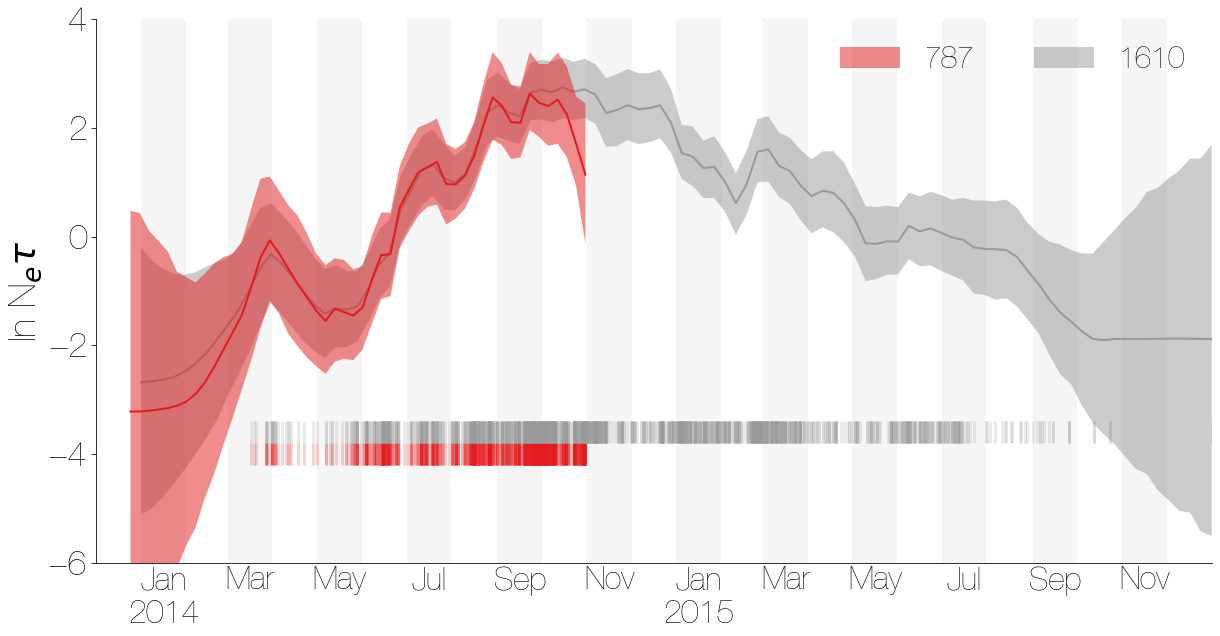

In [14]:
fig,ax = plt.subplots(figsize=(20, 10),facecolor='w') 

datasets=skygrids.keys()

for f in datasets:
#     print skygrids[f].keys()
    grid_pts=sorted(skygrids[f].keys(),key=lambda x:-int(x.split('Size')[-1]))
#     print grid_pts
#     print mostRecent[f],cutoffs[f]
    
    x_grid=np.linspace(mostRecent[f]-cutoffs[f],mostRecent[f],len(grid_pts))
    #print x_grid
    y_grid=[np.mean(skygrids[f][x]) for x in grid_pts]
    hpds=np.array([hpd(skygrids[f][x],0.95) for x in grid_pts])
    
    fc=mpl.cm.Set1(datasets.index(f)/float(len(datasets)-1))
    
    ax.plot(x_grid,y_grid,color=fc,lw=2,zorder=2000-int(f))
    ax.fill_between(x_grid,hpds[:,0],hpds[:,1],facecolor=fc,edgecolor='none',alpha=0.5,zorder=2000-int(f),label=f)
    #ax.plot(x_grid,hpds[:,0],color='k',zorder=2000-int(f),lw=1)
    #ax.plot(x_grid,hpds[:,1],color='k',zorder=2000-int(f),lw=1)
    
    #print [fc]*len(dates[f]),len(dates[f])
    fcs=[fc for q in dates[f]]
    xs=dates[f]
#     print len(fcs),len(dates[f])
    ax.eventplot(xs,colors=[fc],lineoffsets=-4+datasets.index(f)*0.4,linelengths=0.4,linewidths=3,alpha=0.2)
    
xDates=['%04d-%02d-01'%(Y,M) for Y in range(2013,2017) for M in range(1,13)]

every=2
[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#     ax.spines['left'].set_color('none')
#     ax.spines['bottom'].set_color('none')
ax.set_ylabel(r'ln N$_{e}\tau$',size=38)

ax.tick_params(axis='x',size=0,labelsize=32,direction='out')
ax.tick_params(axis='y',size=5,labelsize=34,direction='out')

ax.set_xlim(decimalDate('2013-12-01'),decimalDate('2016-01-01'))
ax.set_ylim(-6,4)
ax.legend(loc=1,ncol=3,fontsize=30,frameon=False)
# plt.savefig(local_output+'EBOV_skygrids.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_skygrids.pdf',dpi=300,bbox_inches='tight')
plt.show()

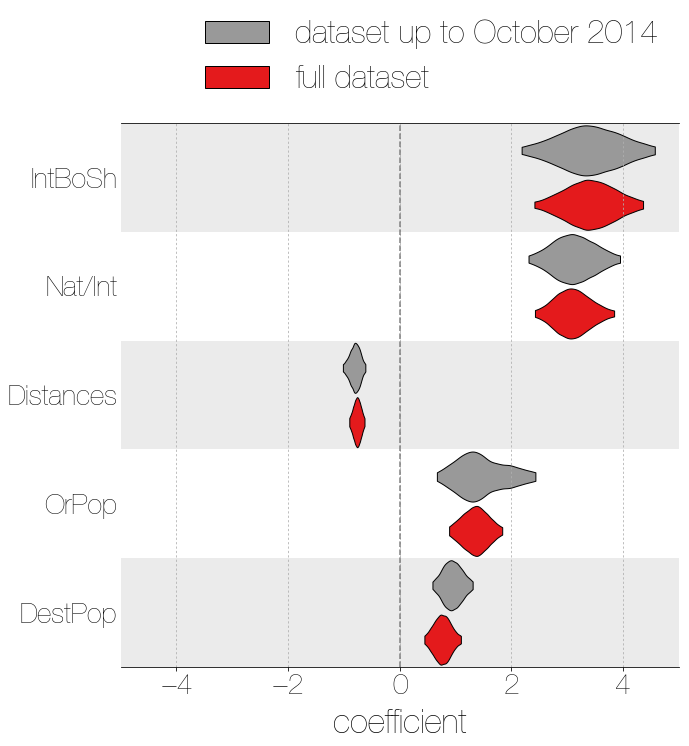

In [15]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 0],wspace=0.0) 

ax1=plt.subplot(gs[0])
#ax2=plt.subplot(gs[1])

datasets=GLMcoeffs.keys()

ylabels=[]
indicators=sorted(GLMinds['1610'].keys(),key=lambda x:np.mean(GLMinds['1610'][x]))
indicators=[q for q in indicators if np.mean(GLMinds['1610'][q])>0.5 or np.mean(GLMinds['787'][q])>0.5]

cs=['#62C0CC','#CC6E62']
cs=[mpl.cm.Set1(1.0),mpl.cm.Set1(0.1)]
labels={'1610':'full dataset','787':'dataset up to October 2014'}
predictor_labels={'within_country':'Nat/Int',
                  'international_border_shared':'IntBoSh',
                  'originPop_Size':'OrPop',
                  'destinationPop_Size':'DestPop',
                  'greatCircleDistances':'Distances',
                 }

for f,d in enumerate(datasets):
    #fc=mpl.cm.Set2(datasets.index(d)/float(len(datasets)-1))
    fc=cs[datasets.index(d)]
    ec='k'
    for p,pred in enumerate(indicators):
        #print pred
        lift=0.15
        base=0.5+lift+p-f*0.5
#         print p,f,base
        pred2=pred.replace('coefIndicator','glmCoefficients')
        
        pred_idx=int(pred.split('coefIndicator')[-1])-1
        
        if predictors[pred_idx] not in ylabels:
            ylabels.append(predictors[pred_idx])
        #print pred,pred2
        support=np.mean(GLMinds[d][pred])
        ax2.barh(base-lift/1.5,support,facecolor=fc,edgecolor=ec,height=0.4)
        
        coeff=[a for a,b in zip(GLMcoeffs[d][pred2],GLMinds[d][pred]) if b==1.0]
        if support<0.0778: ## if BF>3
            coeff=GLMcoeffs[d][pred2]
            
        hpdLo,hpdHi=hpd(coeff,0.95)
        x_grid=np.linspace(hpdLo,hpdHi,100)
        kde=gaussian_kde(coeff)
        y_grid=kde.evaluate(x_grid)
        y_grid=y_grid/y_grid.max()*0.23
        
        if pred_idx==0:
            ax1.fill_between(x_grid,[0.1+base+w for w in y_grid],[0.1+base-w for w in y_grid],facecolor=fc,edgecolor=ec,label=labels[d])
        else:
            ax1.fill_between(x_grid,[0.1+base+w for w in y_grid],[0.1+base-w for w in y_grid],facecolor=fc,edgecolor=ec)
        
        if p%2==0:
            ax1.axhspan(p,p+1.0,facecolor='grey',edgecolor='none',alpha=0.08,zorder=0)
            ax2.axhspan(p,p+1.0,facecolor='grey',edgecolor='none',alpha=0.08,zorder=0)

ax1.set_yticks(np.linspace(0.5,len(ylabels)+0.5,len(ylabels)+1))
ax1.set_yticklabels([predictor_labels[l] for l in ylabels])
            
ax1.axvline(0.0,ls='--',color='grey')


ax1.grid(axis='x',ls=':')
ax1.spines['right'].set_color('none') ## make plot pretty
ax1.spines['left'].set_color('none')
ax1.yaxis.tick_left()
ax1.tick_params(axis='x',labelsize=28,direction='out')
ax1.tick_params(axis='y',labelsize=28,size=0)
ax1.set_xlabel('coefficient',size=34)
ax1.xaxis.set_label_position('bottom')
ax1.xaxis.labelpad=10


ax2.xaxis.tick_top()
ax2.set_xticks(np.linspace(0,1,3))
ax2.set_xticklabels(np.linspace(0,1,3),rotation=90)
ax2.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax2.tick_params(axis='x',size=5,labelsize=28,direction='out',pad=10)
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.set_xlabel('inclusion probability',size=24) ## set x labels for both figures
ax2.xaxis.set_label_position('top')

ax1.legend(frameon=False,fontsize=32,bbox_to_anchor=(0.1, 1.0))

ax1.set_xlim(-5,5)
ax1.set_ylim(0.0,len(ylabels))
ax2.set_ylim(ax1.get_ylim())

# plt.savefig(local_output+'EBOV_sub_coeffs.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_sub_coeffs.pdf',dpi=300,bbox_inches='tight')
plt.show()